<a href="https://colab.research.google.com/github/Enriquebadenas/DP3_G3/blob/main/Copia_de_DP3_2022_05_10_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Project 3 | Grupo 3

## Predicción del riesgo crediticio

In [1]:
#Librerias
import os
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path_dem = "https://raw.githubusercontent.com/Enriquebadenas/DP3_G3/main/datasets/demograficos_diego.csv"
#demograficos_diego es el mismo dataset original - train_demograficos / usamos este porque incorpora las variables país y ciudad ya que ejecutar esa función tarda 20-25 min
path_prev = "https://raw.githubusercontent.com/Enriquebadenas/DP3_G3/main/datasets/train_previous_loan.csv"
path_perf = "https://raw.githubusercontent.com/Enriquebadenas/DP3_G3/main/datasets/train_performance.csv"

path_test_dem = "https://raw.githubusercontent.com/Enriquebadenas/DP3_G3/main/datasets/test_datos_demograficos.csv"
path_test_prev = "https://raw.githubusercontent.com/Enriquebadenas/DP3_G3/main/datasets/test_previous_loan.csv"
path_test_perf = "https://raw.githubusercontent.com/Enriquebadenas/DP3_G3/main/datasets/test_performance.csv"


In [3]:
# Train DataFrames
dem = pd.read_csv(path_dem)
prev = pd.read_csv(path_prev)
df_train_perf = pd.read_csv(path_perf)

#Test DataFrames
df_test_perf = pd.read_csv(path_test_perf)
df_test_dem = pd.read_csv(path_test_dem)
df_test_prev = pd.read_csv(path_test_prev)

## 00_Descripción de los Datasets

### dataset: "train_previous_loan"

In [4]:
#CUSTOMERID - SYSTEMLOANID - Identificadores de clientes y préstamos
prev.describe()

,systemloanid,loannumber,loanamount,totaldue,termdays
count,1.818300e+04,18183.000000,18183.000000,18183.000000,18183.000000
mean,3.018395e+08,4.189353,16501.237420,19573.202931,26.692790
std,9.367767e+04,3.249490,9320.547516,10454.245277,10.946556
min,3.016001e+08,1.000000,3000.000000,3450.000000,15.000000
25%,3.017766e+08,2.000000,10000.000000,11500.000000,15.000000
50%,3.018550e+08,3.000000,10000.000000,13000.000000,30.000000
75%,3.019197e+08,6.000000,20000.000000,24500.000000,30.000000
max,3.020003e+08,26.000000,60000.000000,68100.000000,90.000000


In [5]:
#CUSTOMERID - SYSTEMLOANID - Identificadores de clientes y préstamos
prev.dtypes

customerid          object
systemloanid         int64
loannumber           int64
approveddate        object
creationdate        object
loanamount         float64
totaldue           float64
termdays             int64
closeddate          object
referredby          object
firstduedate        object
firstrepaiddate     object
dtype: object

Variables cuantitativas

In [16]:
# Only the variable "referredby" has missing values = 17.157 sobre 18.183 del total de datos
prev.isna().sum()

Unnamed: 0                     0
customerid                     0
systemloanid                   0
loannumber                     0
approveddate                   0
creationdate                   0
loanamount                     0
totaldue                       0
termdays                       0
closeddate                     0
referredby                 17157
firstduedate                   0
firstrepaiddate                0
diff_approv_closed_date        0
Good_bad_flag                  0
num_prest                      0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


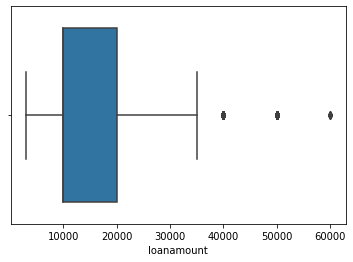

In [17]:
# LOANAMOUNT - Cantidad pedida en el préstamo
prev.loanamount.describe()
sns.boxplot(prev["loanamount"])

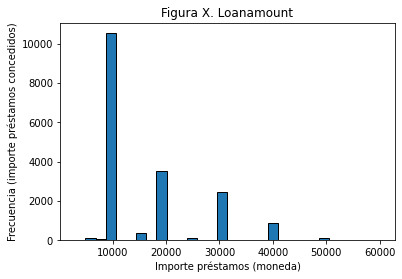

In [18]:
plt.hist(prev.loanamount, edgecolor='black', bins=30)
plt.title('Figura X. Loanamount')
plt.ylabel('Frecuencia (importe préstamos concedidos)')
plt.xlabel('Importe préstamos (moneda)')
plt.show()

In [19]:
prev.loanamount.unique()

array([10000., 20000., 30000., 40000., 25000., 15000.,  5000.,  8000.,
       50000.,  9000., 35000.,  7000.,  4000.,  6000.,  3000., 60000.])

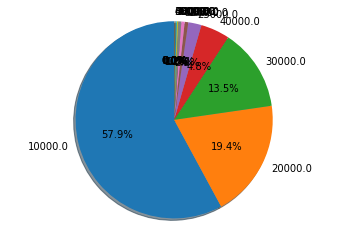

In [20]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = prev.loanamount.unique()
sizes = prev.loanamount.value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Los préstramos concedidos son de cantidades "redondas", los mayoritarios son el 57,9% de 10.000 (moneda), seguidos de los de 20.000 y 30.000.

In [21]:
prev.loanamount.value_counts()

10000.0    10529
20000.0     3524
30000.0     2452
40000.0      867
15000.0      394
50000.0      106
25000.0      100
5000.0        95
8000.0        38
35000.0       27
6000.0        19
7000.0        11
9000.0         9
4000.0         5
60000.0        5
3000.0         2
Name: loanamount, dtype: int64

In [22]:
# TOTALDUE - Cantidad total requerida para liquidar el préstamo; este es el valor del préstamo
# de capital desembolsado + intereses e impuestos
prev.totaldue.describe()

count    18183.000000
mean     19573.202931
std      10454.245277
min       3450.000000
25%      11500.000000
50%      13000.000000
75%      24500.000000
max      68100.000000
Name: totaldue, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


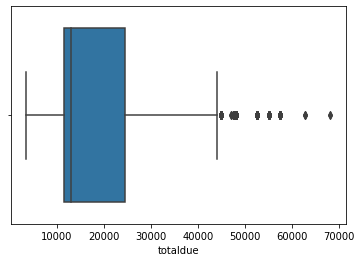

In [23]:
# TOTALDUE - Cantidad total requerida para liquidar el préstamo; este es el valor del préstamo
# de capital desembolsado + intereses e impuestos
sns.boxplot(prev["totaldue"])

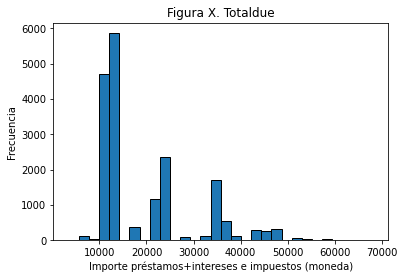

In [24]:
plt.hist(prev.totaldue, edgecolor='black', bins=30)
plt.title('Figura X. Totaldue')
plt.ylabel('Frecuencia')
plt.xlabel('Importe préstamos+intereses e impuestos (moneda)')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


30    11045
15     6115
60      993
90       30
Name: termdays, dtype: int64

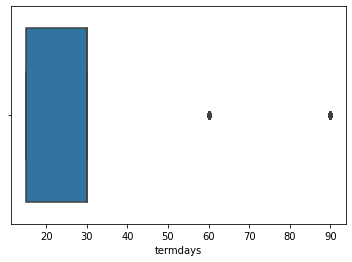

In [25]:
# TERMDAYS - Plazo del préstamo
prev.termdays.describe()
sns.boxplot(prev["termdays"])
prev["termdays"].value_counts()

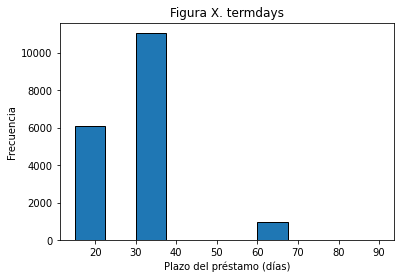

In [26]:
plt.hist(prev.termdays, edgecolor='black', bins=10)
plt.title('Figura X. termdays')
plt.ylabel('Frecuencia')
plt.xlabel('Plazo del préstamo (días)')
plt.show()

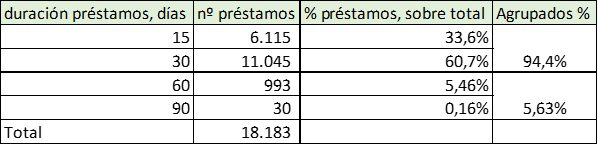

Los préstamos de 90 días apenas suponen un 0,16% del total de los prestamos del dataset. Los de 60 días representan un 5,46% del total.

Variables cualitativas

In [27]:
#APPROVEDDATE - Fecha en la que se aprobó el préstamo
prev.approveddate.describe()

count                   18183
unique                  18172
top       2017-04-20 14:00:44
freq                        2
Name: approveddate, dtype: object

In [28]:
#CREATIONDATE - Fecha en que se creó la solicitud del préstamo
prev.creationdate.describe()

count                   18183
unique                  18173
top       2017-06-12 10:38:36
freq                        2
Name: creationdate, dtype: object

In [29]:
#CLOSEDDATE - Fecha en la cual se liquidó el préstamo
prev.closeddate.describe()

count                   18183
unique                  17955
top       2016-11-07 00:53:42
freq                        5
Name: closeddate, dtype: object

In [30]:
#FIRSTDUEDATE - Fecha del primer pago en caso de que el plazo sea superior a 30 días.
#En el caso de que el plazo sea de más de 60 días, se deben realizar varios pagos mensuales,
#y esta fecha refleja la fecha del primer pago
prev.firstduedate.describe()

count                   18183
unique                    363
top       2017-07-03 00:00:00
freq                      398
Name: firstduedate, dtype: object

In [31]:
#FIRSTREPAIDDATE - Fecha real en la que se hizo el primer pago
prev.firstrepaiddate.describe()

count                   18183
unique                  18011
top       2016-08-04 00:00:00
freq                        7
Name: firstrepaiddate, dtype: object

In [32]:
#LOAN NUMBER - Categorías del préstamo:
prev.loannumber.describe()
prev["loannumber"].value_counts()

1     4344
2     2969
3     2300
4     1860
5     1535
6     1288
7     1036
8      817
9      637
10     446
11     333
12     223
13     146
14      96
15      54
16      33
17      19
18      16
19      10
20       8
21       7
22       2
24       1
23       1
25       1
26       1
Name: loannumber, dtype: int64

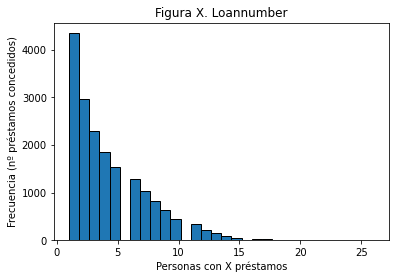

In [33]:
plt.hist(prev.loannumber, edgecolor='black', bins=30)
plt.title('Figura X. Loannumber')
plt.ylabel('Frecuencia (nº préstamos concedidos)')
plt.xlabel('Personas con X préstamos')
plt.show()

### dataset: "train_demograficos"

In [34]:
#CUSTOMERID - TRAIN datos demográficos
dem.describe()

,Unnamed: 0,longitude_gps,latitude_gps
count,4346.000000,4346.000000,4346.000000
mean,2172.500000,4.626189,7.251356
std,1254.726464,7.184832,3.055052
min,0.000000,-118.247009,-33.868818
25%,1086.250000,3.354953,6.470610
50%,2172.500000,3.593302,6.621888
75%,3258.750000,6.545220,7.425052
max,4345.000000,151.209290,71.228069


In [35]:
dem.dtypes

Unnamed: 0                      int64
customerid                     object
birthdate                      object
bank_account_type              object
longitude_gps                 float64
latitude_gps                  float64
bank_name_clients              object
bank_branch_clients            object
employment_status_clients      object
level_of_education_clients     object
Country                        object
city                           object
dtype: object

In [36]:
#Missing values sobre 4346 del total de los datos
dem.isna().sum()

Unnamed: 0                       0
customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4295
employment_status_clients      648
level_of_education_clients    3759
Country                          0
city                          3070
dtype: int64

In [37]:
#BIRTHDATE - Fecha de nacimiento del cliente
dem.birthdate.describe()

count           4346
unique          3297
top       1983-10-19
freq               5
Name: birthdate, dtype: object

In [38]:
#BIRTHDATE - Fecha de nacimiento del cliente
dem.birthdate.describe()
dem["birthdate"].value_counts()

1983-10-19    5
1986-07-04    5
1984-06-28    5
1983-12-16    5
1980-09-22    4
             ..
1990-09-25    1
1982-03-05    1
1980-01-28    1
1993-09-23    1
1989-09-26    1
Name: birthdate, Length: 3297, dtype: int64

In [39]:
#BANK_ACCOUNT_TYPE - Tipo de cuenta bancaria
dem.bank_account_type.describe()

count        4346
unique          3
top       Savings
freq         3425
Name: bank_account_type, dtype: object

In [40]:
#BANK_ACCOUNT_TYPE - Tipo de cuenta bancaria
dem["bank_account_type"].value_counts()

Savings    3425
Other       865
Current      56
Name: bank_account_type, dtype: int64

In [41]:
#BANK_NAME_CLIENTS - Nombre del banco
dem.bank_name_clients.describe()
#dem["bank_name_clients"].value_counts()

count        4346
unique         18
top       GT Bank
freq         1598
Name: bank_name_clients, dtype: object

In [42]:
#BANK_NAME_CLIENTS - Nombre del banco
#dem.bank_name_clients.describe()
dem["bank_name_clients"].value_counts()

GT Bank               1598
First Bank             590
Access Bank            432
UBA                    353
Zenith Bank            301
Diamond Bank           282
EcoBank                150
Stanbic IBTC           145
FCMB                   121
Fidelity Bank          103
Skye Bank              102
Sterling Bank           55
Wema Bank               28
Union Bank              23
Heritage Bank           22
Keystone Bank           19
Standard Chartered      15
Unity Bank               7
Name: bank_name_clients, dtype: int64

In [43]:
#BANK_BRANCH_CLIENTS - Localización del Banco
dem.bank_branch_clients.describe()
#dem["bank_branch_clients"].value_counts()

count       51
unique      45
top       OGBA
freq         3
Name: bank_branch_clients, dtype: object

In [44]:
#BANK_BRANCH_CLIENTS - Localización del Banco
#dem.bank_branch_clients.describe()
dem["bank_branch_clients"].value_counts()

OGBA                                                              3
HEAD OFFICE                                                       2
AJOSE ADEOGUN                                                     2
OREGUN                                                            2
APAPA                                                             2
AKOWONJO                                                          1
47 LAGOS ROAD, IKORODU                                            1
OAU ILE IFE                                                       1
RING ROAD                                                         1
PLOT 999C DANMOLE STREET, ADEOLA ODEKU, VICTORIA ISLAND, LAGOS    1
HERITAGE BANK, DUGBE, IBADAN                                      1
ADEOLA HOPEWELL                                                   1
WHARF ROAD, APAPA                                                 1
ILUPEJU                                                           1
LAGOS                                           

In [45]:
#EMPLOYMENT_STATUS_CLIENTS - Tipo de empleo del cliente
dem.employment_status_clients.describe()
dem.employment_status_clients.value_counts()

Permanent        3146
Self-Employed     348
Student           142
Unemployed         57
Retired             4
Contract            1
Name: employment_status_clients, dtype: int64

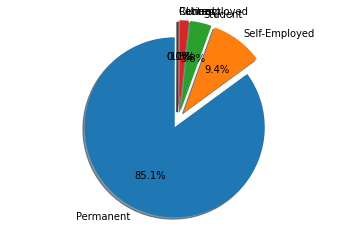

In [46]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = dem.employment_status_clients.unique()
labels = 'Permanent', 'Self-Employed', 'Student', 'Unemployed', 'Retired', 'Contract'
sizes = dem.employment_status_clients.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Arreglar los textos del gráfico

In [47]:
#LEVEL_OF_EDUCATION_CLIENTs - Nivel de estudios del cliente
dem.level_of_education_clients.describe()
dem["level_of_education_clients"].value_counts()

Graduate         420
Secondary         89
Post-Graduate     68
Primary           10
Name: level_of_education_clients, dtype: int64

### dataset: "train_performance"

Este dataset contiene la variable target: "good_bad_flag". El resto de variables son similares al dataset de "train_previous_loan"

In [48]:
df_train_perf.dtypes

customerid        object
systemloanid       int64
loannumber         int64
approveddate      object
creationdate      object
loanamount       float64
totaldue         float64
termdays           int64
referredby        object
good_bad_flag     object
dtype: object

Contiene 4368 clientes únicos. Cada uno de ellos tiene un préstamo (systemloanid) asociado.

In [49]:
#4368 clientes únicos
df_train_perf.groupby("customerid").count()

,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
customerid,,,,,,,,,
8a1088a0484472eb01484669e3ce4e0b,1,1,1,1,1,1,1,0,1
8a1a1e7e4f707f8b014f797718316cad,1,1,1,1,1,1,1,0,1
8a1a32fc49b632520149c3b8fdf85139,1,1,1,1,1,1,1,0,1
8a1eb5ba49a682300149c3c068b806c7,1,1,1,1,1,1,1,0,1
8a1edbf14734127f0147356fdb1b1eb2,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...
8a858fff5a28d297015a33bc2e845305,1,1,1,1,1,1,1,0,1
8a858fff5a36fe68015a37f8550a02a2,1,1,1,1,1,1,1,0,1
8a858fff5a36fe68015a3ac5851618ab,1,1,1,1,1,1,1,0,1


In [50]:
# 0 clientes repetidos
df_train_perf['customerid'].duplicated().sum()

0

Solo la variable referredby contiene missing values

In [51]:
df_train_perf.isna().sum()

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

## 01_Procesamiento

### *train_previous_loan*

In [6]:
#Convertir los campos que contengan fechas a formato "Date_Time"
prev[["approveddate","creationdate","closeddate","firstduedate","firstrepaiddate"]] = prev[["approveddate",
                                                                                             "creationdate",
                                                                                             "closeddate",
                                                                                             "firstduedate",
                                                                                             "firstrepaiddate"]].apply(pd.to_datetime)

#### Creación nuevas variables

A partir de las variables de este dataset, decidimos crear las siguientes:

- "num_prest" = número de préstamos por cliente
- "tipo_int" = tipo de interés de cada préstamo
- "diff_approv_closed_date" = duración en días que tardó el cliente en devolver el préstamo
- "totaldue_y" = suma de todos los importes de los préstamos de cada cliente 
- "tipo_int_y = media de todos los tipos de interés de los préstamos de cada cliente
- "duration_ratio" = ratio del tiempo que tardó el cliente en pagar la totalidad de la deuda

In [7]:
#Número de préstamos por cliente:
prev["num_prest"] = prev.groupby("customerid")["systemloanid"].transform("size")    
prev.num_prest.describe()

count    18183.000000
mean         7.372876
std          4.282959
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         26.000000
Name: num_prest, dtype: float64

In [8]:
#Tipo de interés del préstamo:
prev["tipo_int"] = ((prev["totaldue"] - prev["loanamount"])/prev["loanamount"])
prev.tipo_int.describe()

count    18183.000000
mean         0.203706
std          0.074354
min          0.000000
25%          0.150000
50%          0.190000
75%          0.300000
max          0.300000
Name: tipo_int, dtype: float64

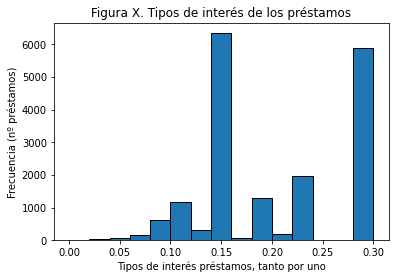

In [9]:
plt.hist(prev.tipo_int, edgecolor='black', bins=15)
plt.title('Figura X. Tipos de interés de los préstamos')
plt.ylabel('Frecuencia (nº préstamos)')
plt.xlabel('Tipos de interés préstamos, tanto por uno')
plt.show()

In [10]:
#Restar la fecha de liquidación del préstamo por la fecha de aprobación para obtener los días que tardó el cliente en pagar la totalidad de la deuda:
prev["diff_approv_closed_date"] = (prev["closeddate"] - prev["approveddate"]).dt.days
prev.diff_approv_closed_date.describe()

count    18183.00000
mean        23.38041
std         13.25201
min          0.00000
25%         14.00000
50%         25.00000
75%         29.00000
max        380.00000
Name: diff_approv_closed_date, dtype: float64

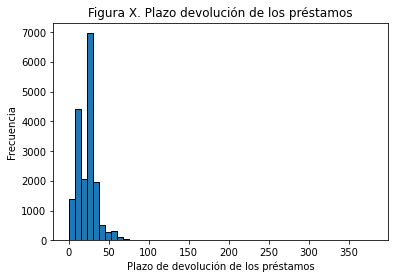

In [11]:
plt.hist(prev.diff_approv_closed_date, edgecolor='black', bins=50)
plt.title('Figura X. Plazo devolución de los préstamos')
plt.ylabel('Frecuencia')
plt.xlabel('Plazo de devolución de los préstamos')
plt.show()

In [12]:
#Ratio del tiempo que tardó el cliente en devolver el préstamo (diff_approv / termdays)
prev["duration_ratio"] = prev["diff_approv_closed_date"] / prev["termdays"]
prev

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,num_prest,tipo_int,diff_approv_closed_date,duration_ratio
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43,11,0.300000,16,0.533333
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00,11,0.300000,29,0.966667
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47,11,0.190000,52,1.733333
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0,11500.0,15,2017-04-24 01:35:52,NaN,2017-04-24,2017-04-24 00:48:43,6,0.150000,14,0.933333
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0,11500.0,15,2017-07-14 21:18:43,NaN,2017-07-03,2017-07-14 21:08:35,2,0.150000,27,1.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18178,8a858899538ddb8e0153a2b555421fc5,301611754,2,2016-04-16 13:36:34,2016-04-16 12:36:28,10000.0,13000.0,30,2016-05-14 00:04:52,NaN,2016-05-16,2016-05-13 18:05:07,13,0.300000,27,0.900000
18179,8a858899538ddb8e0153a2b555421fc5,301761267,9,2016-11-18 14:26:07,2016-11-18 13:25:51,30000.0,34400.0,30,2016-12-13 16:08:57,NaN,2016-12-19,2016-12-13 15:53:48,13,0.146667,25,0.833333
18180,8a858899538ddb8e0153a2b555421fc5,301631653,4,2016-06-12 15:30:56,2016-06-12 14:30:50,10000.0,13000.0,30,2016-07-09 15:39:00,NaN,2016-07-12,2016-07-09 15:23:56,13,0.300000,27,0.900000
18181,8a858f0656b7820c0156c92ca3ba436f,301697691,1,2016-08-27 20:03:45,2016-08-27 19:03:34,10000.0,13000.0,30,2016-10-15 10:17:54,NaN,2016-09-26,2016-10-15 10:02:45,1,0.300000,48,1.600000


In [13]:
#Dataframes con nuevas variables a pasar al train_performance
prev2 = prev.groupby(['customerid'])['totaldue'].sum()
prev3 = prev.groupby(['customerid'])['tipo_int'].mean()
prev4 = prev.groupby(['customerid'])['duration_ratio'].mean()

#### Missing values

Solo la variable "Referredby" tiene valores nulos. Decidimos recodificarla como variable categórica, en la que los "customer_id" relacionados tendrán el valor 1, y los valores vacíos 0.

In [14]:
prev.isna().sum()

customerid                     0
systemloanid                   0
loannumber                     0
approveddate                   0
creationdate                   0
loanamount                     0
totaldue                       0
termdays                       0
closeddate                     0
referredby                 17157
firstduedate                   0
firstrepaiddate                0
num_prest                      0
tipo_int                       0
diff_approv_closed_date        0
duration_ratio                 0
dtype: int64

In [15]:
#Referredby = nan to 0 and customerid to 1
prev["referredby"] = prev["referredby"].fillna(0)
prev["referredby"] = prev["referredby"].apply(lambda x: 1 if x!=0 else 0)
prev["referredby"].value_counts()

0    17157
1     1026
Name: referredby, dtype: int64

### *train_demograficos*

In [16]:
#Convertir los campos que contengan fechas a formato "Date_Time":
dem[["birthdate"]] = dem[["birthdate"]].apply(pd.to_datetime)
#Coordenadas a Float
dem[["longitude_gps", "latitude_gps"]] = dem[["longitude_gps", "latitude_gps"]].astype(float)

#### Creación nuevas variables

A partir de las variables de este dataset, decidimos crear las siguientes variables:


*   "age" - edad del cliente
*   "country" - país desde el cual se realiza la operación
*   "city" - ciudad desde la cual se realiza la operación 

In [17]:
from datetime import datetime
from datetime import date

In [18]:
dem["age"] = dem["birthdate"].apply(lambda x : (pd.datetime.now().year - x.year))
dem["age"] = dem["age"] - 4

dem.age.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


count    4346.000000
mean       33.946618
std         6.135591
min        22.000000
25%        30.000000
50%        33.000000
75%        38.000000
max        57.000000
Name: age, dtype: float64

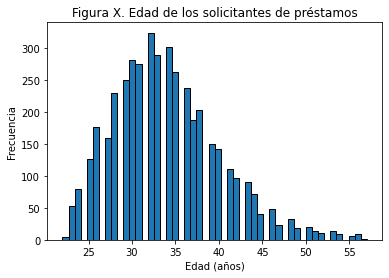

In [19]:
plt.hist(dem.age, edgecolor='black', bins=50)
plt.title('Figura X. Edad de los solicitantes de préstamos')
plt.ylabel('Frecuencia')
plt.xlabel('Edad (años)')
plt.show()

In [20]:
# Función para convertir las coordenadas en Países - mantenerla comentada (tiempo de ejecución 20-25 min)
#El dataset cargado inicialmente ya contiene la columna 
"""
import geocoder

def geo_rev(x):
    g = geocoder.osm([x.latitude_gps, x.longitude_gps], method='reverse').json
    if g:
        return g.get('country')
    else:
        return 'no country'

dem["Country"] = dem[['latitude_gps', 'longitude_gps']].apply(geo_rev, axis=1)
"""

'\nimport geocoder\n\ndef geo_rev(x):\n    g = geocoder.osm([x.latitude_gps, x.longitude_gps], method=\'reverse\').json\n    if g:\n        return g.get(\'country\')\n    else:\n        return \'no country\'\n\ndem["Country"] = dem[[\'latitude_gps\', \'longitude_gps\']].apply(geo_rev, axis=1)\n'

In [21]:
# Función para convertir las coordenadas en Ciudades - mantenerla comentada (tiempo de ejecución 20-25 min)
#El dataset cargado inicialmente ya contiene la columna 
"""
def geo_city(x):
    g = geocoder.osm([x.latitude_gps, x.longitude_gps], method='reverse').json
    if g:
        return g.get('city')
    else:
        return 'no city' 

dem["city"] = dem[['latitude_gps', 'longitude_gps']].apply(geo_city, axis=1)

dem["city"].value_counts()
"""

'\ndef geo_city(x):\n    g = geocoder.osm([x.latitude_gps, x.longitude_gps], method=\'reverse\').json\n    if g:\n        return g.get(\'city\')\n    else:\n        return \'no city\' \n\ndem["city"] = dem[[\'latitude_gps\', \'longitude_gps\']].apply(geo_city, axis=1)\n\ndem["city"].value_counts()\n'

#### Missing values


Observamos que las variables "bank_branch_clients"; "level_of_education_clients" ; "employment_status_clients" ; "city", contienen missing values. 

Borraremos las columnas innecesarias despúes de juntar ambos datasets

In [22]:
dem.isna().sum()

Unnamed: 0                       0
customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4295
employment_status_clients      648
level_of_education_clients    3759
Country                          0
city                          3070
age                              0
dtype: int64

### *train_performance*

In [23]:
#Convertir los campos que contengan fechas a formato "Date_Time"
df_train_perf[["approveddate","creationdate"]] = df_train_perf[["approveddate",
                                                          "creationdate",]].apply(pd.to_datetime)


#### Creación nuevas variables

A partir de las variables de este dataset, decidimos crear la variable:

- "tipo_int" - tipo de interés de cada préstamo

In [24]:
#Tipo de interés del préstamo:
df_train_perf["tipo_int"] = ((df_train_perf["totaldue"] - df_train_perf["loanamount"])/df_train_perf["loanamount"])
df_train_perf.tipo_int.describe()

count    4368.000000
mean        0.217742
std         0.077056
min         0.000000
25%         0.150000
50%         0.225000
75%         0.300000
max         0.300000
Name: tipo_int, dtype: float64

#### Missing values

In [25]:
#Referredby = nan to 0 and customerid to 1
df_train_perf["referredby"] = df_train_perf["referredby"].fillna(0)
df_train_perf["referredby"] = df_train_perf["referredby"].apply(lambda x: 1 if x!=0 else 0)

df_train_perf["referredby"].value_counts()

0    3781
1     587
Name: referredby, dtype: int64

### Join datasets

Borramos columnas innecesarias del dataset "train_demograficos".

In [26]:
dem.drop(["birthdate", "Country", "bank_branch_clients", "city", "Unnamed: 0",
               "level_of_education_clients", "employment_status_clients"], axis=1, inplace=True)

Comprobamos que no hayan missing values en nuestros datasets.

In [27]:
dem.isna().sum()

customerid           0
bank_account_type    0
longitude_gps        0
latitude_gps         0
bank_name_clients    0
age                  0
dtype: int64

In [28]:
df_train_perf.isna().sum()

customerid       0
systemloanid     0
loannumber       0
approveddate     0
creationdate     0
loanamount       0
totaldue         0
termdays         0
referredby       0
good_bad_flag    0
tipo_int         0
dtype: int64

Juntamos los datasets.

In [29]:
# JOIN - Performance con datos demograficos
df_train_all = pd.merge(left=df_train_perf, right=dem, how='left', left_on='customerid', right_on='customerid')
df_train_all = df_train_all.drop_duplicates(subset = ["customerid"])
df_train_all = df_train_all.dropna()
df_train_all.isna().sum()

customerid           0
systemloanid         0
loannumber           0
approveddate         0
creationdate         0
loanamount           0
totaldue             0
termdays             0
referredby           0
good_bad_flag        0
tipo_int             0
bank_account_type    0
longitude_gps        0
latitude_gps         0
bank_name_clients    0
age                  0
dtype: int64

In [30]:
# JOIN - Performance con datos previous loan
# prev2 = suma de los préstamos antiguos de cada cliente
df_train_all = pd.merge(left=df_train_all, right=prev2, how='left', left_on='customerid', right_on='customerid')
#prev3 = media de los tipos de interés de los préstamos antiguos de cada cliente
df_train_all = pd.merge(left=df_train_all, right=prev3, how='left', left_on='customerid', right_on='customerid')
#prev4 = ratio del tiempo que tardó el cliente en pagar la totalidad del préstamo
df_train_all = pd.merge(left=df_train_all, right=prev4, how='left', left_on='customerid', right_on='customerid')
df_train_all.isna().sum()

customerid           0
systemloanid         0
loannumber           0
approveddate         0
creationdate         0
loanamount           0
totaldue_x           0
termdays             0
referredby           0
good_bad_flag        0
tipo_int_x           0
bank_account_type    0
longitude_gps        0
latitude_gps         0
bank_name_clients    0
age                  0
totaldue_y           5
tipo_int_y           5
duration_ratio       5
dtype: int64

In [31]:
#Eliminamos missing values
df_train_all = df_train_all.dropna()

In [32]:
#rename
df_train_all.rename(columns={'tipo_int_x':'tipo_int'}, inplace=True)
df_train_all.rename(columns={'totaldue_x':'totaldue'}, inplace=True)

### Eliminar variables

Identificadores:

- "Customer_id"

- "Systemloanid"

Fechas - no incluibles en el modelo, pero se han empleado para crear otras variables contínuas con info relevante

- "approveddate"

- "creationdate"

In [33]:
# BORRAMOS COLUMNAS DEL DATASET TRAIN MERGED
df_train_all.drop(["customerid", "systemloanid", "approveddate", "creationdate"], axis=1, inplace=True)

In [34]:
# Columnas que mantenemos en el dataset train+demográfico tras limpieza columnas
df_train_all.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag', 'tipo_int', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'age', 'totaldue_y', 'tipo_int_y',
       'duration_ratio'],
      dtype='object')

### Outliers

In [35]:
outl = df_train_all.describe(percentiles=[.25, .5, .75, .90, .95, .99])
outl

,loannumber,loanamount,totaldue,termdays,referredby,tipo_int,longitude_gps,latitude_gps,age,totaldue_y,tipo_int_y,duration_ratio
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,5.193934,17841.605392,21290.954504,29.246324,0.137255,0.217596,4.532037,7.290795,33.900429,82316.968995,0.224492,0.905619
std,3.668213,10746.274326,11930.907156,11.397130,0.344169,0.077167,7.931426,3.272046,6.128180,103488.701053,0.063490,0.314178
min,2.000000,10000.000000,10000.000000,15.000000,0.000000,0.000000,-118.247009,-33.868818,22.000000,5750.000000,0.085568,0.000000
25%,2.000000,10000.000000,13000.000000,30.000000,0.000000,0.150000,3.354830,6.473632,29.000000,13000.000000,0.150000,0.766667
50%,4.000000,10000.000000,13000.000000,30.000000,0.000000,0.225000,3.585039,6.625506,33.000000,36000.000000,0.225000,0.900000
75%,7.000000,20000.000000,24500.000000,30.000000,0.000000,0.300000,6.458061,7.426989,38.000000,109600.000000,0.300000,1.000000
90%,11.000000,30000.000000,39000.000000,30.000000,1.000000,0.300000,7.476951,9.052732,42.000000,223400.000000,0.300000,1.173667
95%,13.000000,40000.000000,44000.000000,60.000000,1.000000,0.300000,7.796117,9.602269,45.000000,312363.750000,0.300000,1.433333
99%,16.000000,50000.000000,55000.000000,60.000000,1.000000,0.300000,8.902741,12.982537,52.000000,460823.750000,0.300000,1.922833


Comprobamos que el 1% de los valores máximos de las variables númericas representan outliers. Decidimos eliminarlos para que nuestro futuro modelo no tienda al overfitting.

In [36]:
#MODIFY
outlier_variable='loanamount'
threshold=50000

#Remove outlier rows
df_train_all = df_train_all.drop(df_train_all[df_train_all[outlier_variable] > threshold].index)

#MODIFY
outlier_variable='totaldue'
threshold=55000

#Remove outlier rows
df_train_all = df_train_all.drop(df_train_all[df_train_all[outlier_variable] > threshold].index)

#MODIFY
outlier_variable='termdays'
threshold=60

#Remove outlier rows
df_train_all = df_train_all.drop(df_train_all[df_train_all[outlier_variable] > threshold].index)

#MODIFY
outlier_variable='totaldue_y'
threshold=460823.75

#Remove outlier rows
df_train_all = df_train_all.drop(df_train_all[df_train_all[outlier_variable] > threshold].index)


#MODIFY
outlier_variable='duration_ratio'
threshold=1.922833

#Remove outlier rows
df_train_all = df_train_all.drop(df_train_all[df_train_all[outlier_variable] > threshold].index)

In [37]:
#missing values
print(round(100*(df_train_all.isnull().sum()/len(df_train_all.index)), 2))

loannumber           0.0
loanamount           0.0
totaldue             0.0
termdays             0.0
referredby           0.0
good_bad_flag        0.0
tipo_int             0.0
bank_account_type    0.0
longitude_gps        0.0
latitude_gps         0.0
bank_name_clients    0.0
age                  0.0
totaldue_y           0.0
tipo_int_y           0.0
duration_ratio       0.0
dtype: float64


### Matriz de correlación

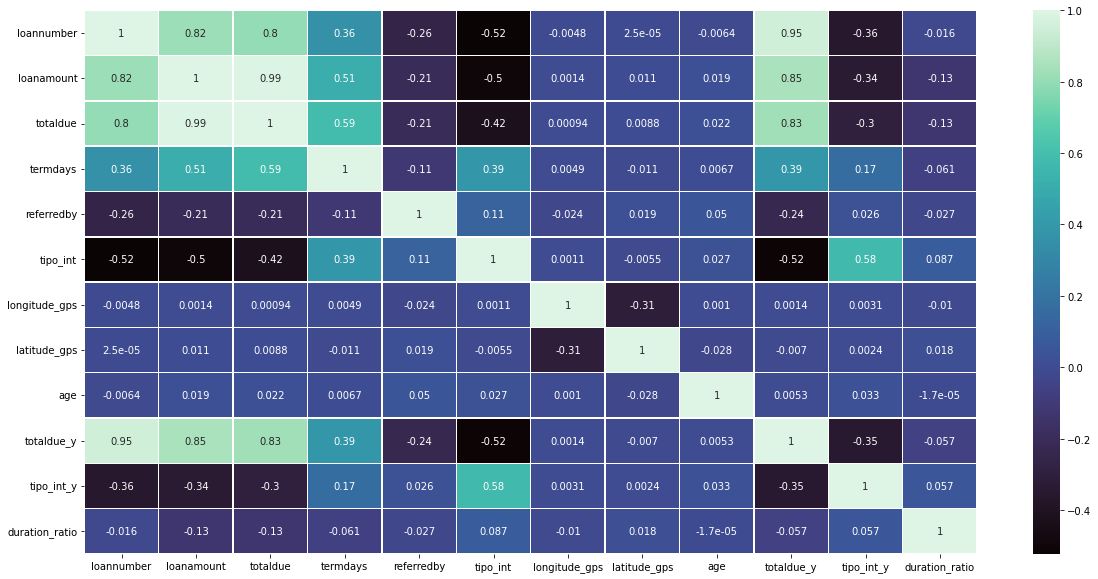

In [38]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))       
sns.heatmap(df_train_all.corr(),annot = True, linewidths=.5, cmap="mako")
plt.show()

In [39]:
#---- Hay correlacion 1 entre totaldue_y y loanamount. Eliminamos loanamount
df_train_all.drop(["loanamount", "totaldue_y"], axis=1, inplace =True)

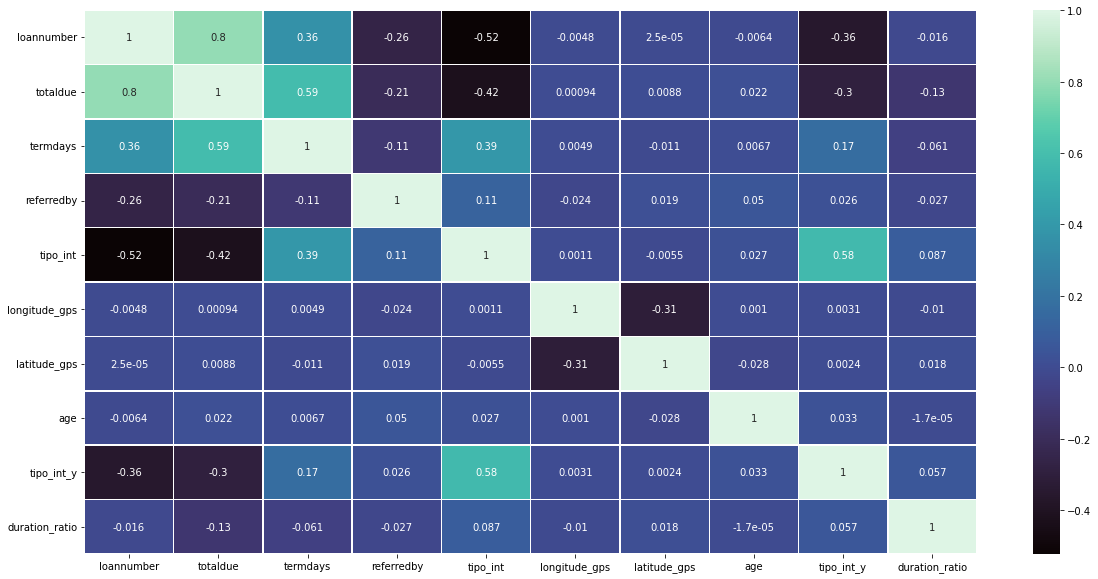

In [40]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))       
sns.heatmap(df_train_all.corr(),annot = True, linewidths=.5, cmap="mako")
plt.show()

In [41]:
df_train_all.columns

Index(['loannumber', 'totaldue', 'termdays', 'referredby', 'good_bad_flag',
       'tipo_int', 'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'age', 'tipo_int_y', 'duration_ratio'],
      dtype='object')

### *test_datasets*

Aplicamos los mismos pasos a los datasets de test, para poder hacer una posterior predicción de nuestros modelos.

In [42]:
#TEST_PERFORMANCE:

#Tipo de interés del préstamo:
df_test_perf["tipo_int"] = ((df_test_perf["totaldue"] - df_test_perf["loanamount"])/df_test_perf["loanamount"])
df_test_perf.tipo_int.describe()

#Referredby = nan to 0 and customerid to 1
df_test_perf["referredby"] = df_test_perf["referredby"].fillna(0)
df_test_perf["referredby"] = df_test_perf["referredby"].apply(lambda x: 1 if x!=0 else 0)


In [43]:
#TEST_DEMOGRAFICOS:
from datetime import datetime
from datetime import date

#Convertir los campos que contengan fechas a formato "Date_Time":
df_test_dem[["birthdate"]] = df_test_dem[["birthdate"]].apply(pd.to_datetime)
#Coordenadas a Float
df_test_dem[["longitude_gps", "latitude_gps"]] = df_test_dem[["longitude_gps", "latitude_gps"]].astype(float)
                                                                                                       
df_test_dem["age"] = df_test_dem["birthdate"].apply(lambda x : (pd.datetime.now().year - x.year))
df_test_dem["age"] = df_test_dem["age"] - 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # Remove the CWD from sys.path while we load stuff.


In [44]:
#TEST_PREVIOUS LOAN
#Convertir los campos que contengan fechas a formato "Date_Time"
df_test_prev[["approveddate","creationdate","closeddate","firstduedate","firstrepaiddate"]] = df_test_prev[["approveddate",
                                                                                             "creationdate",
                                                                                             "closeddate",
                                                                                             "firstduedate",
                                                                                             "firstrepaiddate"]].apply(pd.to_datetime)
#Referredby = nan to 0 and customerid to 1
df_test_prev["referredby"] = df_test_prev["referredby"].fillna(0)
df_test_prev["referredby"] = df_test_prev["referredby"].apply(lambda x: 1 if x!=0 else 0)
df_test_prev["referredby"].value_counts()

#Número de préstamos por cliente:
df_test_prev["num_prest"] = df_test_prev.groupby("customerid")["systemloanid"].transform("size")  
#Tipo de interés del préstamo:
df_test_prev["tipo_int"] = ((df_test_prev["totaldue"] - df_test_prev["loanamount"])/df_test_prev["loanamount"])
#Restar la fecha de liquidación del préstamo por la fecha de aprobación para obtener los días que tardó el cliente en pagar la totalidad de la deuda:
df_test_prev["diff_approv_closed_date"] = (df_test_prev["closeddate"] - df_test_prev["approveddate"]).dt.days
#Ratio tiempo
df_test_prev["duration_ratio"] = df_test_prev["diff_approv_closed_date"] / prev["termdays"]

In [45]:
#Dataframes a juntar con df_test_all
df_test_prev2 = df_test_prev.groupby(['customerid'])['totaldue'].sum()
df_test_prev3 = df_test_prev.groupby(['customerid'])['tipo_int'].mean()
df_test_prev4 = df_test_prev.groupby(['customerid'])['duration_ratio'].mean()

In [46]:
#Borramos columnas innecesarias
df_test_dem.drop(["birthdate", "bank_branch_clients",
               "level_of_education_clients", "employment_status_clients"], axis=1, inplace=True)

In [47]:
#JOIN TEST_DATASETS
df_test_all = pd.merge(left=df_test_perf, right=df_test_dem, how='left', left_on='customerid', right_on='customerid')

In [48]:
df_test_all = df_test_all.drop_duplicates(subset = ["customerid"])
df_test_all.isna().sum()

customerid              0
systemloanid            0
loannumber              0
approveddate            0
creationdate            0
loanamount              0
totaldue                0
termdays                0
referredby              0
tipo_int                0
bank_account_type    1065
longitude_gps        1065
latitude_gps         1065
bank_name_clients    1065
age                  1065
dtype: int64

In [49]:
# test con prev2
df_test_all = pd.merge(left=df_test_all, right=df_test_prev2, how='left', left_on='customerid', right_on='customerid')
#test con prev3
df_test_all = pd.merge(left=df_test_all, right=df_test_prev3, how='left', left_on='customerid', right_on='customerid')
# test con prev4
df_test_all = pd.merge(left=df_test_all, right=df_test_prev4, how='left', left_on='customerid', right_on='customerid')

In [50]:
#Eliminamos missing values
df_test_all = df_test_all.dropna()

In [51]:
#Borramos columnas innecesarias
df_test_all.drop(["customerid", "systemloanid", "approveddate", "creationdate", "loanamount", "totaldue_y"], axis=1, inplace=True)

df_test_all.rename(columns={'tipo_int_x':'tipo_int'}, inplace=True)
df_test_all.rename(columns={'totaldue_x':'totaldue'}, inplace=True)

In [52]:
df_test_all

,loannumber,totaldue,termdays,referredby,tipo_int,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,age,tipo_int_y,duration_ratio
2,6,24500.0,30,0,0.2250,Savings,3.227945,6.586668,UBA,37.0,0.23300,1.533333
4,4,24500.0,30,0,0.2250,Savings,5.248368,13.059864,UBA,43.0,0.25000,0.577778
6,2,11500.0,15,0,0.1500,Savings,5.288827,7.604053,GT Bank,24.0,0.30000,1.000000
10,4,24500.0,30,0,0.2250,Savings,3.339835,7.118107,GT Bank,36.0,0.30000,0.822222
16,3,11500.0,15,0,0.1500,Savings,3.371619,6.605104,GT Bank,29.0,0.22500,0.633333
...,...,...,...,...,...,...,...,...,...,...,...,...
1433,2,13000.0,30,0,0.3000,Savings,6.729505,6.202439,Zenith Bank,25.0,0.30000,0.900000
1435,5,22250.0,15,0,0.1125,Savings,3.529142,6.625488,GT Bank,29.0,0.17375,1.050000
1436,2,13000.0,30,0,0.3000,Savings,3.838206,7.352298,GT Bank,24.0,0.30000,2.600000
1437,2,13000.0,30,1,0.3000,Savings,8.339893,5.028449,Diamond Bank,31.0,0.30000,0.433333


## 02_Clustering

In [53]:
#Importamos las librerías:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as ps
import numpy as np
import seaborn as sns; sns.set()
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [54]:
df_train_all.head()

,loannumber,totaldue,termdays,referredby,good_bad_flag,tipo_int,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,age,tipo_int_y,duration_ratio
0,12,34500.0,30,0,Good,0.1500,Other,3.432010,6.433055,Diamond Bank,46.0,0.229091,0.981818
2,7,22250.0,15,0,Good,0.1125,Other,11.139350,10.292041,EcoBank,34.0,0.175000,1.072222
3,3,11500.0,15,0,Good,0.1500,Savings,3.985770,7.491708,First Bank,41.0,0.225000,1.500000
4,9,44000.0,30,0,Good,0.1000,Other,7.457913,9.076574,GT Bank,32.0,0.258750,0.779167
5,3,13000.0,30,0,Good,0.3000,Savings,3.259444,6.557011,GT Bank,29.0,0.225000,0.850000


In [55]:
#Creamos un dataframe con los campos menos customerid y good_bad_flag: "df_train_all_clust" // con este campo generamos otro dataframe "goodbad"
df_train_all_clust = df_train_all.drop(['good_bad_flag'], axis = 1)
goodbad = df_train_all[['good_bad_flag']]

In [56]:
df_train_all_clust.head()

,loannumber,totaldue,termdays,referredby,tipo_int,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,age,tipo_int_y,duration_ratio
0,12,34500.0,30,0,0.1500,Other,3.432010,6.433055,Diamond Bank,46.0,0.229091,0.981818
2,7,22250.0,15,0,0.1125,Other,11.139350,10.292041,EcoBank,34.0,0.175000,1.072222
3,3,11500.0,15,0,0.1500,Savings,3.985770,7.491708,First Bank,41.0,0.225000,1.500000
4,9,44000.0,30,0,0.1000,Other,7.457913,9.076574,GT Bank,32.0,0.258750,0.779167
5,3,13000.0,30,0,0.3000,Savings,3.259444,6.557011,GT Bank,29.0,0.225000,0.850000


In [57]:
#Generamos dummies de las variables categóricas bank_account_type y bank_num_clients:
dummy_bk = pd.get_dummies(df_train_all_clust[['bank_account_type']], drop_first=True)
dummy_bn = pd.get_dummies(df_train_all_clust[['bank_name_clients']], drop_first=True)
#Añadimos las variables dummies y borramos las categóricas originales:
df_train_all_clust = pd.concat([df_train_all_clust, dummy_bk, dummy_bn], axis=1)
df_train_all_clust = df_train_all_clust.drop(['bank_account_type', 'bank_name_clients'], 1)
df_train_all_clust.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,loannumber,totaldue,termdays,referredby,tipo_int,longitude_gps,latitude_gps,age,tipo_int_y,duration_ratio,...,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank
0,12,34500.0,30,0,0.1500,3.432010,6.433055,46.0,0.229091,0.981818,...,0,0,0,0,0,0,0,0,0,0
2,7,22250.0,15,0,0.1125,11.139350,10.292041,34.0,0.175000,1.072222,...,0,0,0,0,0,0,0,0,0,0
3,3,11500.0,15,0,0.1500,3.985770,7.491708,41.0,0.225000,1.500000,...,0,0,0,0,0,0,0,0,0,0
4,9,44000.0,30,0,0.1000,7.457913,9.076574,32.0,0.258750,0.779167,...,0,0,0,0,0,0,0,0,0,0
5,3,13000.0,30,0,0.3000,3.259444,6.557011,29.0,0.225000,0.850000,...,0,0,0,0,0,0,0,0,0,0


In [58]:
#Realizamos el mismo proceso para TEST:

#Generamos dummies de las variables categóricas bank_account_type y bank_num_clients:
dummy_bk = pd.get_dummies(df_test_all[['bank_account_type']], drop_first=True)
dummy_bn = pd.get_dummies(df_test_all[['bank_name_clients']], drop_first=True)
#Añadimos las variables dummies y borramos las categóricas originales:
df_test_all_clust = pd.concat([df_test_all, dummy_bk, dummy_bn], axis=1)
df_test_all_clust = df_test_all_clust.drop(['bank_account_type', 'bank_name_clients'], 1)
df_test_all_clust.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,loannumber,totaldue,termdays,referredby,tipo_int,longitude_gps,latitude_gps,age,tipo_int_y,duration_ratio,...,bank_name_clients_GT Bank,bank_name_clients_Heritage Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank
2,6,24500.0,30,0,0.225,3.227945,6.586668,37.0,0.233,1.533333,...,0,0,0,0,0,1,0,0,0,0
4,4,24500.0,30,0,0.225,5.248368,13.059864,43.0,0.250,0.577778,...,0,0,0,0,0,1,0,0,0,0
6,2,11500.0,15,0,0.150,5.288827,7.604053,24.0,0.300,1.000000,...,1,0,0,0,0,0,0,0,0,0
10,4,24500.0,30,0,0.225,3.339835,7.118107,36.0,0.300,0.822222,...,1,0,0,0,0,0,0,0,0,0
16,3,11500.0,15,0,0.150,3.371619,6.605104,29.0,0.225,0.633333,...,1,0,0,0,0,0,0,0,0,0


###Elbow Method: Obtener el número de clusters

In [59]:
distortions = []
K = range(1,10)
for k in K:
  kmeans_mod = KMeans(n_clusters = k)
  kmeans_mod.fit(df_train_all_clust)
  distortions.append(kmeans_mod.inertia_)

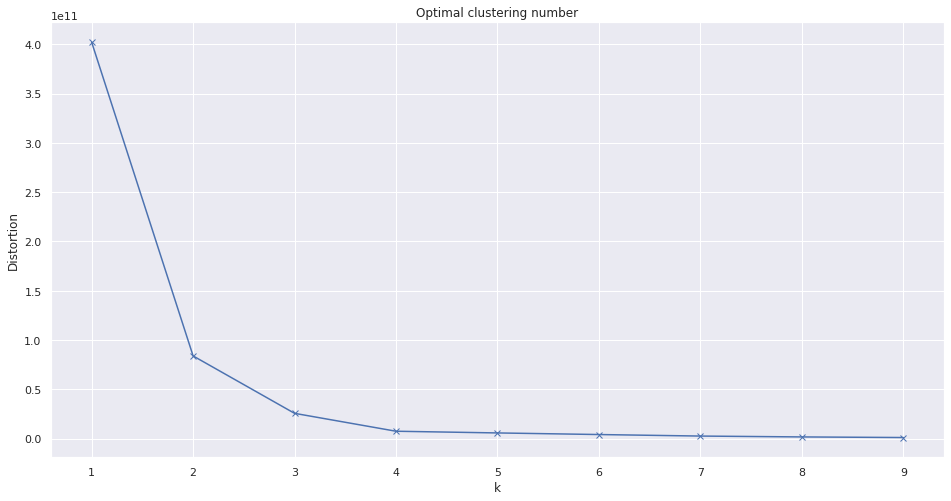

In [60]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal clustering number')
plt.show()

Tras visualizar el Elbow Method, podemos concretar que el número de clusters óptimo es 2.


##K-Means

###K-means con Train:

In [61]:
cluster_mod =  KMeans(n_clusters = 2, max_iter = 300)
cluster_mod.fit(df_train_all_clust)

KMeans(n_clusters=2)

In [62]:
df_train_all_ = df_train_all

df_train_all_['Cluster'] = cluster_mod.labels_
df_train_all_ = df_train_all_.reset_index()
df_train_all_

,index,loannumber,totaldue,termdays,referredby,good_bad_flag,tipo_int,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,age,tipo_int_y,duration_ratio,Cluster
0,0,12,34500.0,30,0,Good,0.1500,Other,3.432010,6.433055,Diamond Bank,46.0,0.229091,0.981818,1
1,2,7,22250.0,15,0,Good,0.1125,Other,11.139350,10.292041,EcoBank,34.0,0.175000,1.072222,0
2,3,3,11500.0,15,0,Good,0.1500,Savings,3.985770,7.491708,First Bank,41.0,0.225000,1.500000,0
3,4,9,44000.0,30,0,Good,0.1000,Other,7.457913,9.076574,GT Bank,32.0,0.258750,0.779167,1
4,5,3,13000.0,30,0,Good,0.3000,Savings,3.259444,6.557011,GT Bank,29.0,0.225000,0.850000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173,3264,2,11500.0,15,1,Bad,0.1500,Savings,3.302387,6.568690,GT Bank,39.0,0.150000,1.066667,0
3174,3265,2,13000.0,30,0,Bad,0.3000,Savings,4.607358,8.460608,FCMB,29.0,0.300000,0.866667,0
3175,3266,3,11500.0,15,0,Bad,0.1500,Savings,3.976842,7.409129,First Bank,29.0,0.150000,1.500000,0
3176,3267,2,13000.0,30,1,Bad,0.3000,Savings,3.986089,7.386796,Skye Bank,28.0,0.300000,1.000000,0


Para visualizar los clusters, utilizaremos PCA para mapear solamente dos variables:

In [63]:
var_pca = PCA(n_components=2)
var_pca_train = var_pca.fit_transform(df_train_all_clust)
var_pca_df = pd.DataFrame(data = var_pca_train, columns = ['PCA_1', 'PCA_2'])
pca_df_train = pd.concat([var_pca_df, df_train_all_[['Cluster']]], axis=1)
pca_df_train


,PCA_1,PCA_2,Cluster
0,13665.473695,-6.496731,1
1,1415.466441,-14.291336,0
2,-9334.532624,-8.901553,0
3,23165.471166,-10.915374,1
4,-7834.524998,5.376600,0
...,...,...,...
3173,-9334.532898,-8.842805,0
3174,-7834.525234,5.480390,0
3175,-9334.532769,-8.767236,0
3176,-7834.525256,5.475239,0


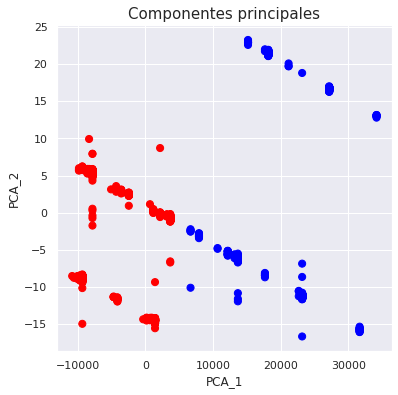

In [64]:
fig = plt.figure(figsize = (6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PCA_1', fontsize = 12)
ax.set_ylabel('PCA_2', fontsize = 12)
ax.set_title('Componentes principales', fontsize = 15)

color_theme = np.array(["red", "blue"])
ax.scatter(x = pca_df_train.PCA_1, y = pca_df_train.PCA_2,
          c=color_theme[pca_df_train.Cluster], s = 50)
plt.show()

In [65]:
print (cluster_mod.inertia_)

83826163616.37997


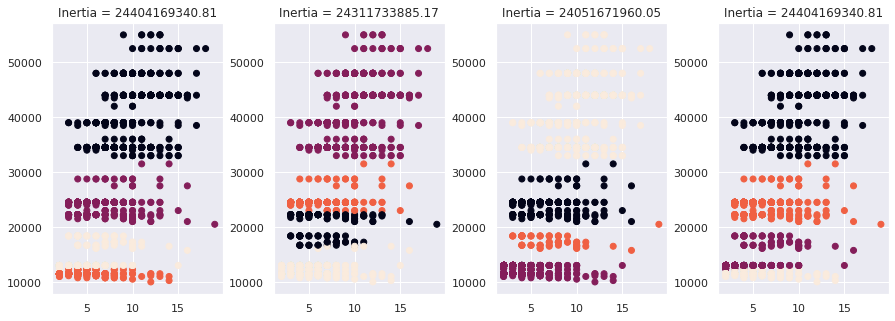

In [66]:
# creating graph in one line
fig, ax = plt.subplots(1, 4, gridspec_kw={'wspace': 0.3}, figsize=(15,5))

# for loop 
for i in range(4):
    km = KMeans(n_clusters = 4, init='random', n_init=1, random_state=i)
    km.fit(df_train_all_clust)
    ax[i].scatter(x= df_train_all_clust.iloc[:, 0], y=df_train_all_clust.iloc[:, 1], c= km.labels_)

#     printing the interia with graphs
    ax[i].set_title(f"Inertia = {round(km.inertia_, 2)}");

###K-means con Test:

In [67]:
cluster_mod_test =  KMeans(n_clusters = 2, max_iter = 300)
cluster_mod_test.fit(df_test_all_clust)

KMeans(n_clusters=2)

In [68]:
df_test_all_ = df_test_all

df_test_all_['Cluster'] = cluster_mod_test.labels_
df_test_all_ = df_test_all.reset_index()
df_test_all_

,index,loannumber,totaldue,termdays,referredby,tipo_int,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,age,tipo_int_y,duration_ratio,Cluster
0,2,6,24500.0,30,0,0.2250,Savings,3.227945,6.586668,UBA,37.0,0.23300,1.533333,0
1,4,4,24500.0,30,0,0.2250,Savings,5.248368,13.059864,UBA,43.0,0.25000,0.577778,0
2,6,2,11500.0,15,0,0.1500,Savings,5.288827,7.604053,GT Bank,24.0,0.30000,1.000000,0
3,10,4,24500.0,30,0,0.2250,Savings,3.339835,7.118107,GT Bank,36.0,0.30000,0.822222,0
4,16,3,11500.0,15,0,0.1500,Savings,3.371619,6.605104,GT Bank,29.0,0.22500,0.633333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,1433,2,13000.0,30,0,0.3000,Savings,6.729505,6.202439,Zenith Bank,25.0,0.30000,0.900000,0
380,1435,5,22250.0,15,0,0.1125,Savings,3.529142,6.625488,GT Bank,29.0,0.17375,1.050000,0
381,1436,2,13000.0,30,0,0.3000,Savings,3.838206,7.352298,GT Bank,24.0,0.30000,2.600000,0
382,1437,2,13000.0,30,1,0.3000,Savings,8.339893,5.028449,Diamond Bank,31.0,0.30000,0.433333,0


De esta manera, al aplicarlo a test podemos observar cómo el modelo predice a qué cliente le asigna en un cluster u otro.

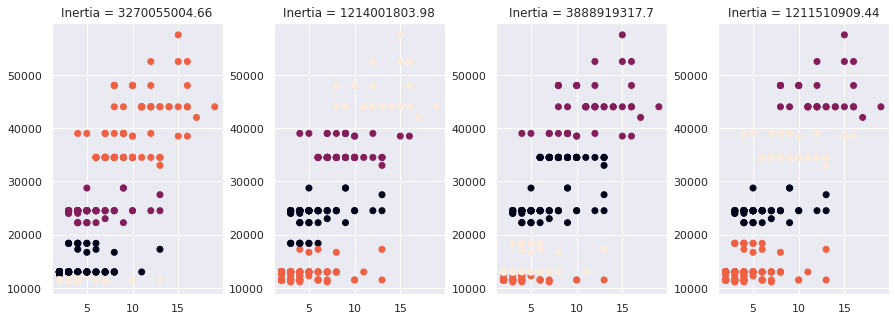

In [69]:
# creating graph in one line
fig, ax = plt.subplots(1, 4, gridspec_kw={'wspace': 0.3}, figsize=(15,5))

# for loop 
for i in range(4):
    km = KMeans(n_clusters = 4, init='random', n_init=1, random_state=i)
    km.fit(df_test_all_clust)
    ax[i].scatter(x= df_test_all_clust.iloc[:, 0], y=df_test_all_clust.iloc[:, 1], c= km.labels_)

#     printing the interia with graphs
    ax[i].set_title(f"Inertia = {round(km.inertia_, 2)}");

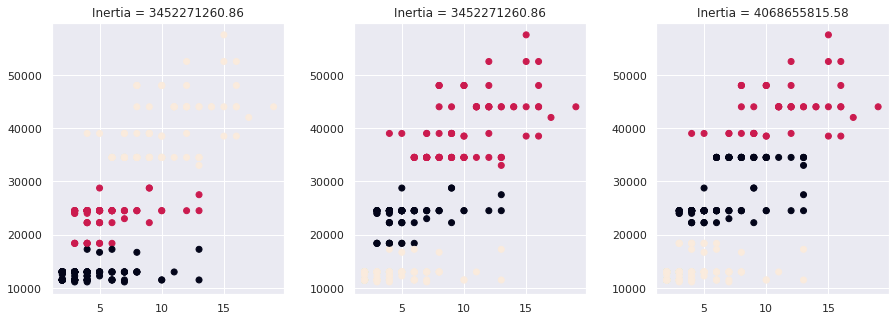

In [70]:
# creating graph in one line
fig, ax = plt.subplots(1, 3, gridspec_kw={'wspace': 0.3}, figsize=(15,5))

# for loop 
for i in range(3):
    km = KMeans(n_clusters = 3, init='random', n_init=1, random_state=i)
    km.fit(df_test_all_clust)
    ax[i].scatter(x= df_test_all_clust.iloc[:, 0], y=df_test_all_clust.iloc[:, 1], c= km.labels_)

#     printing the interia with graphs
    ax[i].set_title(f"Inertia = {round(km.inertia_, 2)}");

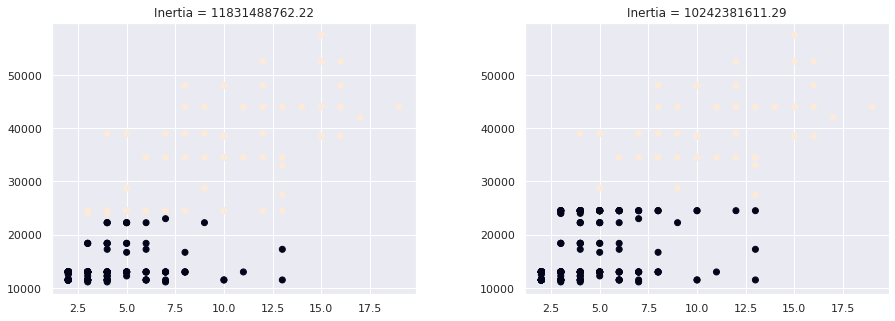

In [71]:
# creating graph in one line
fig, ax = plt.subplots(1, 2, gridspec_kw={'wspace': 0.3}, figsize=(15,5))

# for loop 
for i in range(2):
    km = KMeans(n_clusters = 2, init='random', n_init=1, random_state=i)
    km.fit(df_test_all_clust)
    ax[i].scatter(x= df_test_all_clust.iloc[:, 0], y=df_test_all_clust.iloc[:, 1], c= km.labels_)

#     printing the interia with graphs
    ax[i].set_title(f"Inertia = {round(km.inertia_, 2)}");

## 03_Modelos

###Modelo XGBoost:

In [114]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn import metrics

In [115]:
df_train_all_xgb = df_train_all
df_train_all_xgb

,loannumber,totaldue,termdays,referredby,good_bad_flag,tipo_int,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,age,tipo_int_y,duration_ratio,Cluster
0,12,34500.0,30,0,1,0.1500,Other,3.432010,6.433055,Diamond Bank,46.0,0.229091,0.981818,1
2,7,22250.0,15,0,1,0.1125,Other,11.139350,10.292041,EcoBank,34.0,0.175000,1.072222,0
3,3,11500.0,15,0,1,0.1500,Savings,3.985770,7.491708,First Bank,41.0,0.225000,1.500000,0
4,9,44000.0,30,0,1,0.1000,Other,7.457913,9.076574,GT Bank,32.0,0.258750,0.779167,1
5,3,13000.0,30,0,1,0.3000,Savings,3.259444,6.557011,GT Bank,29.0,0.225000,0.850000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,2,11500.0,15,1,0,0.1500,Savings,3.302387,6.568690,GT Bank,39.0,0.150000,1.066667,0
3265,2,13000.0,30,0,0,0.3000,Savings,4.607358,8.460608,FCMB,29.0,0.300000,0.866667,0
3266,3,11500.0,15,0,0,0.1500,Savings,3.976842,7.409129,First Bank,29.0,0.150000,1.500000,0
3267,2,13000.0,30,1,0,0.3000,Savings,3.986089,7.386796,Skye Bank,28.0,0.300000,1.000000,0


In [116]:
#Generamos dummies de las variables categóricas bank_account_type y bank_name_clients:
dummy_bk = pd.get_dummies(df_train_all_xgb[['bank_account_type']], drop_first=True)
dummy_bn = pd.get_dummies(df_train_all_xgb[['bank_name_clients']], drop_first=True)
#Añadimos las variables dummies y borramos las categóricas originales:
df_train_all_xgb = pd.concat([df_train_all_xgb, dummy_bk, dummy_bn], axis=1)
df_train_all_xgb = df_train_all_xgb.drop(['bank_account_type', 'bank_name_clients'], 1)
df_train_all_xgb.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,loannumber,totaldue,termdays,referredby,good_bad_flag,tipo_int,longitude_gps,latitude_gps,age,tipo_int_y,...,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank
0,12,34500.0,30,0,1,0.1500,3.432010,6.433055,46.0,0.229091,...,0,0,0,0,0,0,0,0,0,0
2,7,22250.0,15,0,1,0.1125,11.139350,10.292041,34.0,0.175000,...,0,0,0,0,0,0,0,0,0,0
3,3,11500.0,15,0,1,0.1500,3.985770,7.491708,41.0,0.225000,...,0,0,0,0,0,0,0,0,0,0
4,9,44000.0,30,0,1,0.1000,7.457913,9.076574,32.0,0.258750,...,0,0,0,0,0,0,0,0,0,0
5,3,13000.0,30,0,1,0.3000,3.259444,6.557011,29.0,0.225000,...,0,0,0,0,0,0,0,0,0,0


In [117]:
#Pasamos la variable categórica 'good_bad_flag'a 0 y 1 :

df_train_all_xgb.replace({'good_bad_flag': {'Good': 1, 'Bad': 0}},inplace = True)

df_train_all_xgb


,loannumber,totaldue,termdays,referredby,good_bad_flag,tipo_int,longitude_gps,latitude_gps,age,tipo_int_y,...,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank
0,12,34500.0,30,0,1,0.1500,3.432010,6.433055,46.0,0.229091,...,0,0,0,0,0,0,0,0,0,0
2,7,22250.0,15,0,1,0.1125,11.139350,10.292041,34.0,0.175000,...,0,0,0,0,0,0,0,0,0,0
3,3,11500.0,15,0,1,0.1500,3.985770,7.491708,41.0,0.225000,...,0,0,0,0,0,0,0,0,0,0
4,9,44000.0,30,0,1,0.1000,7.457913,9.076574,32.0,0.258750,...,0,0,0,0,0,0,0,0,0,0
5,3,13000.0,30,0,1,0.3000,3.259444,6.557011,29.0,0.225000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,2,11500.0,15,1,0,0.1500,3.302387,6.568690,39.0,0.150000,...,0,0,0,0,0,0,0,0,0,0
3265,2,13000.0,30,0,0,0.3000,4.607358,8.460608,29.0,0.300000,...,0,0,0,0,0,0,0,0,0,0
3266,3,11500.0,15,0,0,0.1500,3.976842,7.409129,29.0,0.150000,...,0,0,0,0,0,0,0,0,0,0
3267,2,13000.0,30,1,0,0.3000,3.986089,7.386796,28.0,0.300000,...,0,1,0,0,0,0,0,0,0,0


In [118]:
#Normalización de las variables que no están en un rango de (0,1):
col_normalized = ['loannumber',
 'totaldue',
 'termdays',
 'longitude_gps',
 'latitude_gps',
 'age']
scaler = StandardScaler()
df_train_all_xgb[col_normalized] = scaler.fit_transform(df_train_all_xgb[col_normalized])
df_train_all_xgb

,loannumber,totaldue,termdays,referredby,good_bad_flag,tipo_int,longitude_gps,latitude_gps,age,tipo_int_y,...,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank
0,2.047139,1.214646,0.116388,0,1,0.1500,-0.136171,-0.260592,1.965544,0.229091,...,0,0,0,0,0,0,0,0,0,0
2,0.576701,0.125813,-1.345594,0,1,0.1125,0.854215,0.924401,0.009183,0.175000,...,0,0,0,0,0,0,0,0,0,0
3,-0.599650,-0.829693,-1.345594,0,1,0.1500,-0.065013,0.064492,1.150393,0.225000,...,0,0,0,0,0,0,0,0,0,0
4,1.164876,2.059048,0.116388,0,1,0.1000,0.381154,0.551162,-0.316878,0.258750,...,0,0,0,0,0,0,0,0,0,0
5,-0.599650,-0.696367,0.116388,0,1,0.3000,-0.158345,-0.222529,-0.805968,0.225000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,-0.893738,-0.829693,-1.345594,1,0,0.1500,-0.152827,-0.218942,0.824333,0.150000,...,0,0,0,0,0,0,0,0,0,0
3265,-0.893738,-0.696367,0.116388,0,0,0.3000,0.014861,0.362016,-0.805968,0.300000,...,0,0,0,0,0,0,0,0,0,0
3266,-0.599650,-0.829693,-1.345594,0,0,0.1500,-0.066160,0.039134,-0.805968,0.150000,...,0,0,0,0,0,0,0,0,0,0
3267,-0.893738,-0.696367,0.116388,1,0,0.3000,-0.064972,0.032276,-0.968998,0.300000,...,0,1,0,0,0,0,0,0,0,0


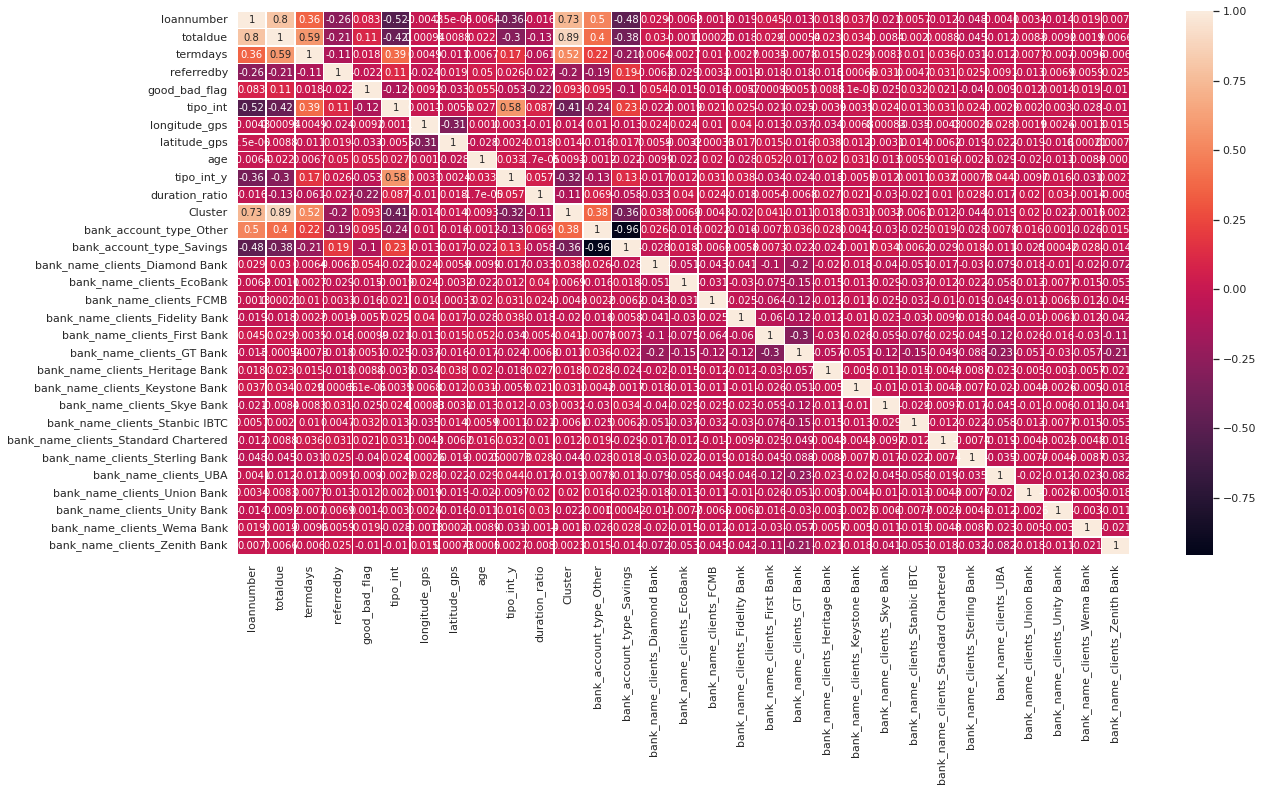

In [119]:
%matplotlib inline

# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(df_train_all_xgb.corr(),annot = True, linewidths=.5)
plt.show()

In [120]:
df_train_all_xgb = df_train_all_xgb.drop(['bank_account_type_Other','loannumber'], 1)
df_train_all_xgb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,totaldue,termdays,referredby,good_bad_flag,tipo_int,longitude_gps,latitude_gps,age,tipo_int_y,duration_ratio,...,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank
0,1.214646,0.116388,0,1,0.1500,-0.136171,-0.260592,1.965544,0.229091,0.981818,...,0,0,0,0,0,0,0,0,0,0
2,0.125813,-1.345594,0,1,0.1125,0.854215,0.924401,0.009183,0.175000,1.072222,...,0,0,0,0,0,0,0,0,0,0
3,-0.829693,-1.345594,0,1,0.1500,-0.065013,0.064492,1.150393,0.225000,1.500000,...,0,0,0,0,0,0,0,0,0,0
4,2.059048,0.116388,0,1,0.1000,0.381154,0.551162,-0.316878,0.258750,0.779167,...,0,0,0,0,0,0,0,0,0,0
5,-0.696367,0.116388,0,1,0.3000,-0.158345,-0.222529,-0.805968,0.225000,0.850000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,-0.829693,-1.345594,1,0,0.1500,-0.152827,-0.218942,0.824333,0.150000,1.066667,...,0,0,0,0,0,0,0,0,0,0
3265,-0.696367,0.116388,0,0,0.3000,0.014861,0.362016,-0.805968,0.300000,0.866667,...,0,0,0,0,0,0,0,0,0,0
3266,-0.829693,-1.345594,0,0,0.1500,-0.066160,0.039134,-0.805968,0.150000,1.500000,...,0,0,0,0,0,0,0,0,0,0
3267,-0.696367,0.116388,1,0,0.3000,-0.064972,0.032276,-0.968998,0.300000,1.000000,...,0,1,0,0,0,0,0,0,0,0


In [121]:
data_Y = df_train_all_xgb['good_bad_flag']
data_X = df_train_all_xgb.drop(['good_bad_flag'], axis = 1)

In [122]:
data_X_Train, data_X_Test, data_Y_Train, data_Y_Test = train_test_split(data_X, data_Y, test_size = 0.2)

In [123]:
data_train = xgb.DMatrix(data_X_Train, label = data_Y_Train)
data_test = xgb.DMatrix(data_X_Train, label = data_Y_Train)

In [124]:
data_Y_Pred = xgboost_mod.predict(data_X_Test)
data_Y_Pred

NameError: ignored

In [ ]:
xgboost_mod = xgb.XGBClassifier()
xgboost_mod.fit(data_X_Train, data_Y_Train)

xgboost_accuracy = accuracy_score(data_Y_Test, data_Y_Pred)
print("Accuracy: %.2f%%" % (xgboost_accuracy * 100.0))

In [ ]:
data_Y_Expected  = data_Y_Test
print(metrics.confusion_matrix(data_Y_Expected, data_Y_Pred))

La precisión de este modelo es del:

In [ ]:
xgboost_accuracy = accuracy_score(data_Y_Test, data_Y_Pred)
print("Accuracy: %.2f%%" % (xgboost_accuracy * 100.0))

El modelo comete muchos fallos a la hora de predecir. Obtenemos 131 falsos positivos. Rechazamos el modelo.

In [ ]:
print(xgboost_mod.feature_importances_)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,10))
bar_list = list(data_X_Test.columns)
plt.xticks(rotation=90)
plt.barh(bar_list, xgboost_mod.feature_importances_)
plt.title('Feature importance. XGBoost')
plt.show()

###Random Forest:

In [112]:
#Utilizamos los datos obtenidos en XGBoost: 
from sklearn.ensemble import RandomForestClassifier
modelo = RandomForestClassifier(
            n_estimators = 10,
            criterion='mse',
            max_depth=None,
            max_features= 'auto',
            oob_score = False,
            n_jobs = -1,
            random_state = 123
)
#Creamos el modelo:
RandomForestClassifier()


modelo = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
modelo.fit(data_X_Train, data_Y_Train)

NameError: ignored

In [113]:
#Realizamos las predicciones:
predicciones = modelo.predict(X = data_X_Test)
predicciones

NameError: ignored

In [ ]:
import sklearn.metrics
sklearn.metrics.confusion_matrix(data_Y_Test, predicciones)

In [ ]:
sklearn.metrics.accuracy_score(data_Y_Test, predicciones)

In [ ]:
modelo.feature_importances_

In [ ]:
plt.figure(figsize=(7,10))
plt.barh(data_X_Test.columns, modelo.feature_importances_)
plt.title('Feature importance. Random Forest')

### Árbol de decisión

In [72]:
#Librerías
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

In [73]:
df_train_all_tree = df_train_all
df_test_all_tree = df_test_all

In [74]:
df_train_all_tree.columns

Index(['loannumber', 'totaldue', 'termdays', 'referredby', 'good_bad_flag',
       'tipo_int', 'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'age', 'tipo_int_y', 'duration_ratio', 'Cluster'],
      dtype='object')

In [75]:
#Encode variables
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [76]:
#Convertimos las variables categóricas a numéricas
df_train_all_tree = MultiColumnLabelEncoder(columns = ['bank_account_type',"bank_name_clients", "good_bad_flag"]).fit_transform(df_train_all_tree)

In [77]:
df_train_all_tree

,loannumber,totaldue,termdays,referredby,good_bad_flag,tipo_int,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,age,tipo_int_y,duration_ratio,Cluster
0,12,34500.0,30,0,1,0.1500,1,3.432010,6.433055,1,46.0,0.229091,0.981818,1
2,7,22250.0,15,0,1,0.1125,1,11.139350,10.292041,2,34.0,0.175000,1.072222,0
3,3,11500.0,15,0,1,0.1500,2,3.985770,7.491708,5,41.0,0.225000,1.500000,0
4,9,44000.0,30,0,1,0.1000,1,7.457913,9.076574,6,32.0,0.258750,0.779167,1
5,3,13000.0,30,0,1,0.3000,2,3.259444,6.557011,6,29.0,0.225000,0.850000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,2,11500.0,15,1,0,0.1500,2,3.302387,6.568690,6,39.0,0.150000,1.066667,0
3265,2,13000.0,30,0,0,0.3000,2,4.607358,8.460608,3,29.0,0.300000,0.866667,0
3266,3,11500.0,15,0,0,0.1500,2,3.976842,7.409129,5,29.0,0.150000,1.500000,0
3267,2,13000.0,30,1,0,0.3000,2,3.986089,7.386796,9,28.0,0.300000,1.000000,0


In [78]:
#Movemos la variable target: "good_bad_flag" a la primera posición de la tabla
first_column = df_train_all_tree.pop("good_bad_flag")
df_train_all_tree.insert(0, "good_bad_flag", first_column)

In [79]:
#Elegimos variables independientes
X = df_train_all_tree.values[:,1:14]
#Elegimos variable target: "good_bad_flag"
Y = df_train_all_tree.values[:, 0]

#### Separación train y test

In [80]:
#Split dataset en test y train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1)

#### Modelo

In [81]:
#Funcion para el training
clf_entropy = DecisionTreeClassifier(random_state = 100)

#Modelo y resultado conjunto train
clf_entropy.fit(X_train, y_train)
clf_entropy.score(X_test, y_test)

0.7264150943396226

In [82]:
clf_entropy.feature_importances_

array([0.06593502, 0.01837931, 0.00682618, 0.00862952, 0.02230277,
       0.0174245 , 0.183207  , 0.20515107, 0.07153935, 0.13042765,
       0.07338214, 0.19510977, 0.00168573])

#### Visualización

[Text(0.6448639509599959, 0.9821428571428571, 'X[11] <= 1.062\ngini = 0.339\nsamples = 2860\nvalue = [618, 2242]'),
 Text(0.445152840092574, 0.9464285714285714, 'X[4] <= 0.292\ngini = 0.281\nsamples = 2373\nvalue = [402, 1971]'),
 Text(0.24641280871933693, 0.9107142857142857, 'X[3] <= 0.5\ngini = 0.247\nsamples = 1471\nvalue = [212, 1259]'),
 Text(0.13349134833901477, 0.875, 'X[6] <= 3.935\ngini = 0.233\nsamples = 1310\nvalue = [176, 1134]'),
 Text(0.03432257202058686, 0.8392857142857143, 'X[8] <= 1.5\ngini = 0.199\nsamples = 777\nvalue = [87, 690]'),
 Text(0.00855557783570617, 0.8035714285714286, 'X[9] <= 23.5\ngini = 0.055\nsamples = 106\nvalue = [3, 103]'),
 Text(0.004277788917853085, 0.7678571428571429, 'X[0] <= 12.0\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.0021388944589265423, 0.7321428571428571, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.006416683376779627, 0.7321428571428571, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.012833366753559254, 0.76785714

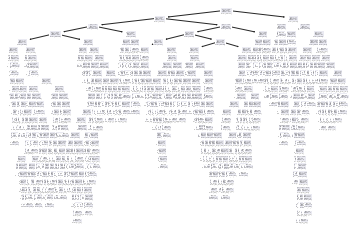

In [83]:
tree.plot_tree(clf_entropy.fit(X_train, y_train))

In [84]:
import graphviz

dot_data= tree.export_graphviz(clf_entropy, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("banco") 

'banco.pdf'

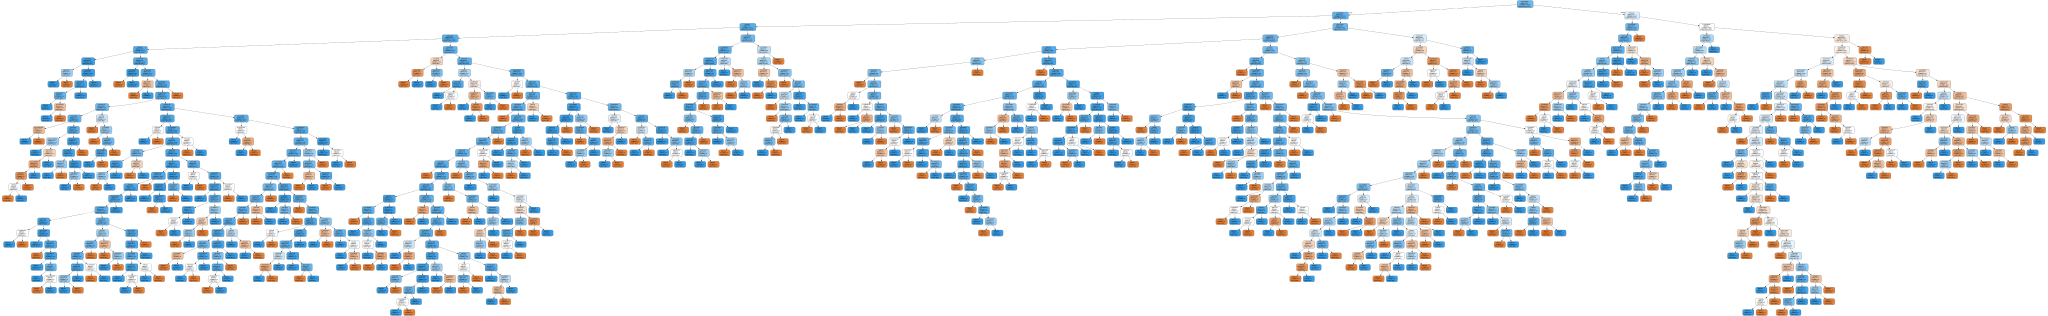

In [85]:
dot_data = tree.export_graphviz(clf_entropy, 
                                out_file=None,
                                filled=True, 
                                rounded=True,
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [86]:
from pydotplus import graph_from_dot_data
import pydotplus
from IPython.display import Image

In [87]:
dot_data = tree.export_graphviz(clf_entropy)
graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

Nuestro nodo raíz será la variable "tipo_int_y".

Lo ha dividido en la siguiente regla tipo_int_y <= 1.088 Y se han creado 2 ramas o decisiones:

- TRUE: tipo_int_y <= 1.062 

- FALSE: tipo_int_y > 1.062

También obtenemos datos del índice de gini, el número de patrones que tenemos en ese nodo (en este caso al ser el nodo raíz todos), los calores que toma y la clase que predice.


#### Predicción

In [88]:
#Predict
y_pred_en = clf_entropy.predict(X_test)

Comprobamos las primeras predicciones

In [89]:
print(y_test[0:5])
print(y_pred_en[0:5])

[1. 1. 1. 0. 1.]
[0. 0. 0. 0. 0.]


#### Resultados y matriz de confusión

Importamos la libreria para hacer la matriz de confusión y el accuracy.

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc

In [91]:
confusion_matrix(y_test, y_pred_en)

array([[ 23,  41],
       [ 46, 208]])

In [92]:
acc(y_test, y_pred_en)

0.7264150943396226

In [93]:
df_test_all

,loannumber,totaldue,termdays,referredby,tipo_int,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,age,tipo_int_y,duration_ratio,Cluster
2,6,24500.0,30,0,0.2250,Savings,3.227945,6.586668,UBA,37.0,0.23300,1.533333,0
4,4,24500.0,30,0,0.2250,Savings,5.248368,13.059864,UBA,43.0,0.25000,0.577778,0
6,2,11500.0,15,0,0.1500,Savings,5.288827,7.604053,GT Bank,24.0,0.30000,1.000000,0
10,4,24500.0,30,0,0.2250,Savings,3.339835,7.118107,GT Bank,36.0,0.30000,0.822222,0
16,3,11500.0,15,0,0.1500,Savings,3.371619,6.605104,GT Bank,29.0,0.22500,0.633333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,2,13000.0,30,0,0.3000,Savings,6.729505,6.202439,Zenith Bank,25.0,0.30000,0.900000,0
1435,5,22250.0,15,0,0.1125,Savings,3.529142,6.625488,GT Bank,29.0,0.17375,1.050000,0
1436,2,13000.0,30,0,0.3000,Savings,3.838206,7.352298,GT Bank,24.0,0.30000,2.600000,0
1437,2,13000.0,30,1,0.3000,Savings,8.339893,5.028449,Diamond Bank,31.0,0.30000,0.433333,0


In [94]:
#Predicción en test
MultiColumnLabelEncoder(columns = ['bank_account_type',"bank_name_clients"]).fit_transform(df_test_all_tree)
df_test_all_tree = MultiColumnLabelEncoder(columns = ['bank_account_type',"bank_name_clients"]).fit_transform(df_test_all_tree)

X_test = df_test_all_tree.values

y_pred_en = clf_entropy.predict(X_test)
y_pred_en

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 1.

### Regresión Logística

#### Data Preparation

In [95]:
# Cambio de nombre porque el código es copiado

# Habrá que eliminar esta primera línea ¿? o mejor sería renombrar las variables para que no se note tanto el copy

data =df_train_all
tipo_int = df_train_all['tipo_int']
target = df_train_all['good_bad_flag']

In [96]:
#TARGET VARIABLE
tgt='good_bad_flag'

In [97]:
#LIST OF CATEGORICAL VARIABLES WITH TWO POSSIBLE VALUES

varlist0 = ['good_bad_flag']

varlist =  ['referredby', 'good_bad_flag']


#LIST OF CATEGORICAL VARIABLES WITH MORE THAN TWO POSSIBLE VALUES

varlist2 = ['bank_account_type', 'bank_name_clients']

#LIST OF CONTINUOUS VARIABLES

varlist3=['loannumber','totaldue','termdays','tipo_int','tipo_int','longitude_gps','latitude_gps','age']

# Defining the map function
def binary_map(x):
    return x.map({'Good': 1, 'Bad': 0})

# Applying the function to the housing list
data[varlist0] = data[varlist0].apply(binary_map)

# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(data[varlist2], drop_first=True)

# Adding the results to the master dataframe
data = pd.concat([data, dummy1], axis=1)

# We have created dummies for the below variables, so we can drop them
data = data.drop(varlist2, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [98]:
data

,loannumber,totaldue,termdays,referredby,good_bad_flag,tipo_int,longitude_gps,latitude_gps,age,tipo_int_y,...,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank
0,12,34500.0,30,0,1,0.1500,3.432010,6.433055,46.0,0.229091,...,0,0,0,0,0,0,0,0,0,0
2,7,22250.0,15,0,1,0.1125,11.139350,10.292041,34.0,0.175000,...,0,0,0,0,0,0,0,0,0,0
3,3,11500.0,15,0,1,0.1500,3.985770,7.491708,41.0,0.225000,...,0,0,0,0,0,0,0,0,0,0
4,9,44000.0,30,0,1,0.1000,7.457913,9.076574,32.0,0.258750,...,0,0,0,0,0,0,0,0,0,0
5,3,13000.0,30,0,1,0.3000,3.259444,6.557011,29.0,0.225000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,2,11500.0,15,1,0,0.1500,3.302387,6.568690,39.0,0.150000,...,0,0,0,0,0,0,0,0,0,0
3265,2,13000.0,30,0,0,0.3000,4.607358,8.460608,29.0,0.300000,...,0,0,0,0,0,0,0,0,0,0
3266,3,11500.0,15,0,0,0.1500,3.976842,7.409129,29.0,0.150000,...,0,0,0,0,0,0,0,0,0,0
3267,2,13000.0,30,1,0,0.3000,3.986089,7.386796,28.0,0.300000,...,0,1,0,0,0,0,0,0,0,0


In [99]:
# Putting feature variable to X
X = data.drop([tgt], axis=1)

# Putting response variable to y
y = data[tgt]

#Normalizing continous variables
scaler = StandardScaler()
X[varlist3]=scaler.fit_transform(X[varlist3])

#Checking the target variable rate
print(f'The {tgt} rate is {round((sum(data[tgt])/len(data[tgt].index))*100,2)}%')

The good_bad_flag rate is 78.54%


#### Correlations

If the correlation is high between two dummy variables, we can remove one of them because the target variable can be explained with the other.

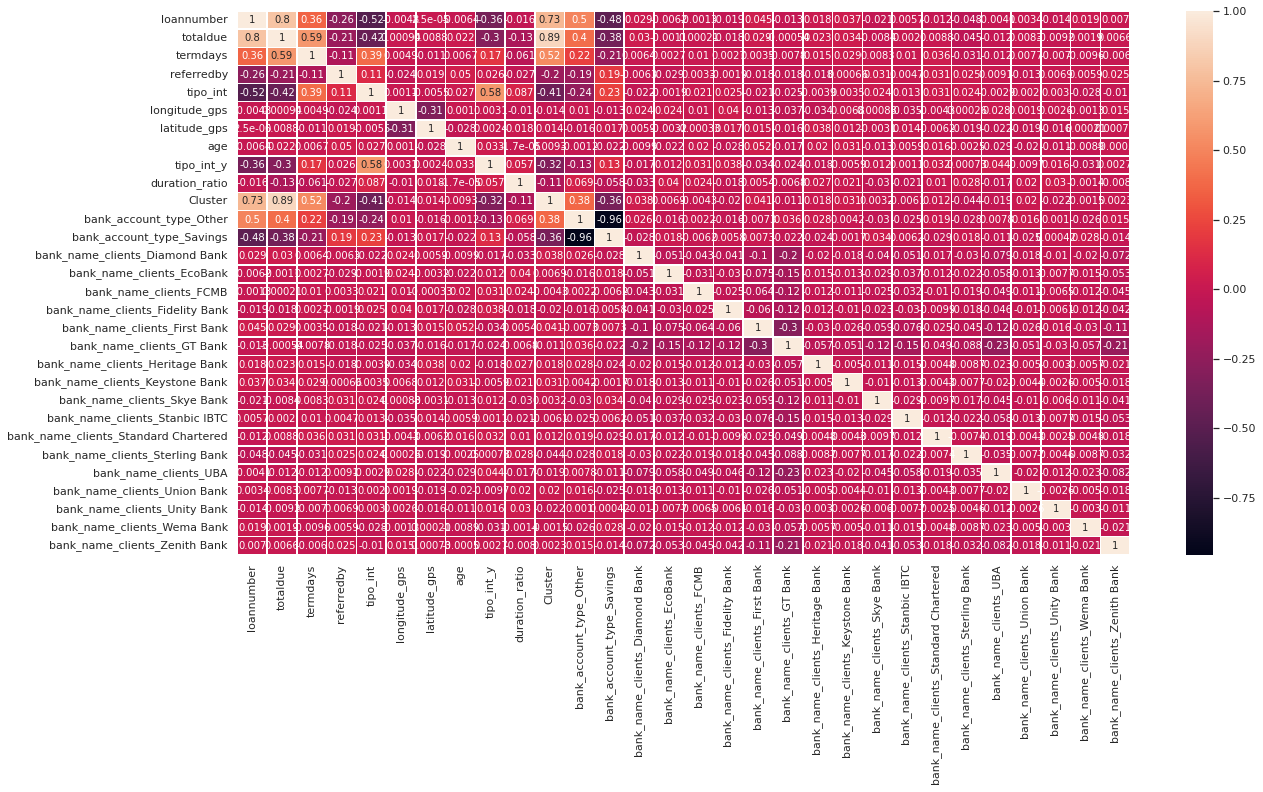

In [100]:
%matplotlib inline

# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X.corr(),annot = True, linewidths=.5)
plt.show()

In [101]:
#MODIFY LIST

dummylist=['bank_account_type_Other']

# droping variables
X = X.drop(dummylist, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


#### Building the model

In [102]:
# Logistic regression model
logm1 = sm.GLM(y,(sm.add_constant(X)), family = sm.families.Binomial())
print(logm1.fit().summary())
print('\nIf there are variables with P>|z| greater than 0.05, we should remove them.')

                 Generalized Linear Model Regression Results                  
Dep. Variable:          good_bad_flag   No. Observations:                 3178
Model:                            GLM   Df Residuals:                     3148
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1524.6
Date:                Thu, 12 May 2022   Deviance:                       3049.2
Time:                        17:43:02   Pearson chi2:                 3.26e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [103]:
# Solo mantenemos las Variables con p < 0.05 por ser significativas al CI 95%
col = ['loannumber','age','bank_account_type_Savings','tipo_int']

X = X[col]
X_train_sm = sm.add_constant(X)
logm2 = sm.GLM(y,X_train_sm, family = sm.families.Binomial())
res = logm2.fit() #hace el cálculo del modelo
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          good_bad_flag   No. Observations:                 3178
Model:                            GLM   Df Residuals:                     3173
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1614.9
Date:                Thu, 12 May 2022   Deviance:                       3229.7
Time:                        17:43:02   Pearson chi2:                 3.17e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.8025      0.125     14.429      0.000       1.558       2.047
loannumber                   -0.0163      0.060     -0.274      0.784      -0.133       0.101
age                           0.1440      0.045      3.184      0.001       0.055       0.233
bank_account_type_Savings    -0.5783      0.139     -4.162      0.000      -0.851      -0.306
tipo_int                     -0.2575      0.052     -4.915      0.000      -0.360      -0.155
=============================================================================================
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


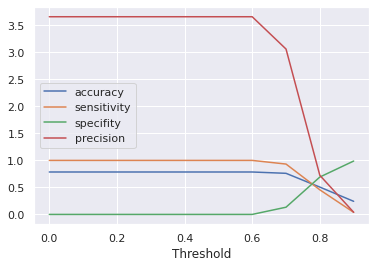

In [104]:
# Drop loannumber
X = X[col]
X_train_sm = sm.add_constant(X)

# Getting the predicted values on the train set

y_train_pred = res.predict(X_train_sm)

# Creating a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({tgt:y.values, tgt+'_Prob':y_train_pred})

# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final[tgt+'_Prob'].map(lambda x: 1 if x > i else 0)

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['Threshold','accuracy','sensitivity','specifity','precision'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final[tgt], y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    precision = cm1[1,1]/(cm1[1,0]+cm1[0,1])
    specifity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specifity,precision]

# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='Threshold', y=['accuracy','sensitivity','specifity','precision'])
plt.show()

In [105]:
# MODIFY. Select threshold

threshold = 0.3

In [106]:
# Predicting the Target probability at threshold cutoff
y_train_pred_final['final_predicted'] = y_train_pred_final.good_bad_flag.map( lambda x: 1 if x > threshold else 0)
y_train_pred_final.drop(num,axis=1).head()

,good_bad_flag,good_bad_flag_Prob,final_predicted
0,1,0.907699,1
2,1,0.896119,1
3,1,0.836634,1
4,1,0.894778,1
5,1,0.699495,1


In [107]:
# Confusion matrix for the final model
print('============================================')
confusion2 = confusion_matrix(y_train_pred_final[tgt], y_train_pred_final.final_predicted )
print(f'Confusion Matrix for Threshold = {threshold}')
print(confusion2)
print('============================================')

# Let's check the overall accuracy.
accuracy = round(accuracy_score(y_train_pred_final[tgt], y_train_pred_final.final_predicted),2)
print(f'Accuracy : {accuracy}')

# Assigning values
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# The sensitivity of our logistic regression model
sensitivity = round(TP/float(TP+FN),2)
print(f'Sensitivity : {sensitivity}')

# Let us calculate specifity
specifity = round(TN/float(TN+FP),2)
print(f'Specifity : {specifity}')

# Let us calculate precision
precision = round(TP/float(TP+FP),2)
print(f'Precision : {precision}')

Confusion Matrix for Threshold = 0.3
[[ 682    0]
 [   0 2496]]
Accuracy : 1.0
Sensitivity : 1.0
Specifity : 1.0
Precision : 1.0


El modelo funciona fatal

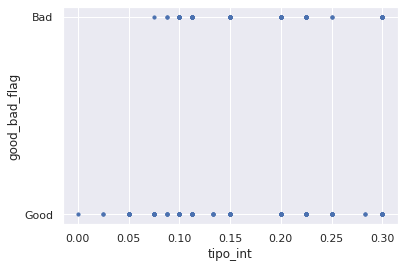

In [108]:
import matplotlib.pyplot as plt

plt.scatter(tipo_int, target, s=10, c='b')
plt.xlabel('tipo_int')
plt.ylabel('good_bad_flag')
plt.show()

In [109]:
# Calculando el menor tipo de interés que no se ha devuelto

data[['tipo_int','good_bad_flag']].sort_values('tipo_int').loc[data['good_bad_flag'] == 0].head(1)

,tipo_int,good_bad_flag
683,0.075,0


HACK: SI PRESTAMOS A TIPOS MENORES DE 7.5% PAGAN SIEMPRE

#### Data Prediction

In [110]:
df_test_all.loc[df_test_all['tipo_int'] < 0.075, 'good_bad_flag'] = 'Safe'
df_test_all.loc[df_test_all['tipo_int'] >= 0.075, 'good_bad_flag'] = 'Not Safe'
df_test_all

,loannumber,totaldue,termdays,referredby,tipo_int,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,age,tipo_int_y,duration_ratio,Cluster,good_bad_flag
2,6,24500.0,30,0,0.2250,Savings,3.227945,6.586668,UBA,37.0,0.23300,1.533333,0,Not Safe
4,4,24500.0,30,0,0.2250,Savings,5.248368,13.059864,UBA,43.0,0.25000,0.577778,0,Not Safe
6,2,11500.0,15,0,0.1500,Savings,5.288827,7.604053,GT Bank,24.0,0.30000,1.000000,0,Not Safe
10,4,24500.0,30,0,0.2250,Savings,3.339835,7.118107,GT Bank,36.0,0.30000,0.822222,0,Not Safe
16,3,11500.0,15,0,0.1500,Savings,3.371619,6.605104,GT Bank,29.0,0.22500,0.633333,0,Not Safe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,2,13000.0,30,0,0.3000,Savings,6.729505,6.202439,Zenith Bank,25.0,0.30000,0.900000,0,Not Safe
1435,5,22250.0,15,0,0.1125,Savings,3.529142,6.625488,GT Bank,29.0,0.17375,1.050000,0,Not Safe
1436,2,13000.0,30,0,0.3000,Savings,3.838206,7.352298,GT Bank,24.0,0.30000,2.600000,0,Not Safe
1437,2,13000.0,30,1,0.3000,Savings,8.339893,5.028449,Diamond Bank,31.0,0.30000,0.433333,0,Not Safe


In [111]:
#Checking the target variable rate
df_test_all['good_bad_flag'].value_counts()

Not Safe    380
Safe          4
Name: good_bad_flag, dtype: int64